### Rascunho - Machine Learning - Ocultacao Estelar

>> Script basico para carregar curvas de luz

Testar K-Means

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import astropy.units as u
from astropy.time import Time
import pandas as pd
# from sora import __version__
# print('Sora version:',__version__) # Fazer um print da versão do SORA para garantir que estamos usando a correta

# from sora import Observer, Occultation, Star, LightCurve
# from sora.extra import draw_ellipse, ChiSquare

# import seaborn as sns
# #from pandas_profiling import ProfileReport
# pd.options.display.float_format = '{:,.2f}'.format
# %matplotlib inline

In [27]:
from sora import __version__
print('Sora version:',__version__) # Fazer um print da versão do SORA para garantir que estamos usando a correta

from sora import Observer, Occultation, Star, LightCurve
from sora.extra import draw_ellipse, ChiSquare

SORA version: 0.3.1
Sora version: 0.3.1


### 1) Ideia inicial: Juntar Features mais importantes de cada curva e achatar para uma dimensão

Peguei 3 curvas para começar. 2 Positivas e 1 negativa. Primeira tentativa:

> Flux.max - Flux.min

> Media Movel Flux: Flux.max - Flux.min -> Média móvel deve ter como parâmetro tamanho da curva

> dFlux.max - dFlux.min

> Flux.std

> Pegar media movel std e criar as Features: Distancia std.max - std.min, std.mean



Outras ideias: 


> Skewness e curtose (pra capturar assimetrias sutis)

> Slope médio entre pontos sucessivos (pode capturar quedas abruptas)

> Diferença média - mediana

> Número de “outliers” negativos (fluxo muito abaixo da média)

> Entropia da curva (medida de complexidade)

> FFT ou DWT simplificada (algumas componentes dominantes)

> Área sob a curva (integral) ou "energy"


Parte do princípio de que a maior parte dos pontos é fora do evento

> Ideias: (1) dividir ordenar pelo Fluxo/temp -> curva em quartis -> media e desvio padrão entre quartis iterativamente -> verificar fora de 5sigma (tem ocultação)

>(2) dividir a propria curva em quartis e achar media movel 

>(3) calcular savgol invés de media movel


In [16]:
def moving_average(df, column, window):
    # self.df['SMA_' + str(window)] = self.df['close'].rolling(window=window).mean() #criando coluna no data frame com a media movel
    df_new = df[column].rolling(window=window).mean()
    return df_new

 - Espaço para formatar curvas de luz para o formato: 
 > .dat Time, Flux, dFlux

Lendo .dat com várias colunas:

In [60]:
curve_fulldat = np.loadtxt('lc_andrewScheck.dat')
curve_fulldat_complete = pd.DataFrame(data = curve_Tumbler,columns = ['Frames', 'Tempo (sec)', '?','?', '?', '?', 'Flux', 'dFlux', 'calibrador_Flux','?','?'])
#curve_fulldat_complete['Flux'] = 10*curve_fulldat_complete['Flux']
#curve_fulldat_complete['dFlux'] = 10*curve_fulldat_complete['dFlux']
curve_fulldat_complete = curve_fulldat_complete.drop(columns=['?'])
curve_fulldat_complete =  curve_fulldat_complete.drop(columns=['calibrador_Flux', 'Frames'])
curve_fulldat_complete.index = curve_fulldat_complete['Tempo (sec)']
curve_fulldat_complete =  curve_fulldat_complete.drop(columns=['Tempo (sec)'])
curve_fulldat_complete

In [68]:
curve_fulldat_complete.to_csv('lc_andrewScheck_corrected.dat') #Estaremos salvando como CSV -> delete o nome das colunas e substitua "," por " "

In [108]:
# Usando SORA
#lc = LightCurve(name='Andrew', 
#                file = 'lc_andrewScheck.dat', 
#                #usecols = [3,9,10], #Lembrete, Python começa na coluna 0 !!!!
#                usecols = [0,1,2], #Lembrete, Python começa na coluna 0 !!!!
#                exptime = 0.52)
#lc.plot_lc()

In [82]:
np.loadtxt('lc_Kitting.dat')

array([[2.45911385e+06, 8.00994783e-01, 1.43461996e-01],
       [2.45911385e+06, 9.44282412e-01, 1.68161003e-01],
       [2.45911385e+06, 9.97273461e-01, 1.78033823e-01],
       ...,
       [2.45911385e+06, 1.18479844e+00, 2.08475872e-01],
       [2.45911385e+06, 1.15368898e+00, 2.03405466e-01],
       [2.45911385e+06, 1.05377412e+00, 1.85343025e-01]])

Ler curvas de luz padronizadas para confirmar se é positivo/negativo e formatar:

<Axes: xlabel='Tempo (sec)'>

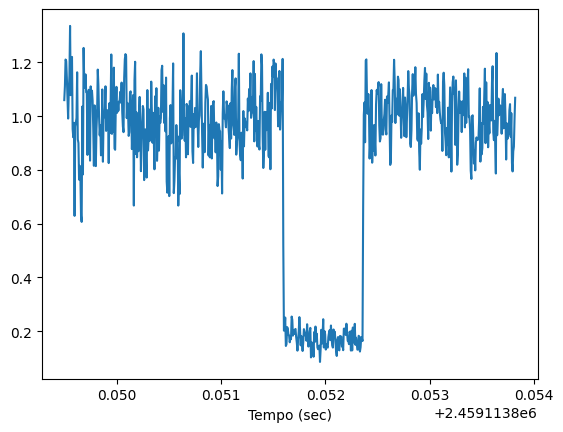

In [107]:
curve_Kai = np.loadtxt('lc_Bardecker.dat')#, usecols=[3,9, 10])
curve_Kai_complete = pd.DataFrame(data = curve_Kai,columns = ['Tempo (sec)', 'Flux','dFlux'])
curve_Kai_complete.index = curve_Kai_complete['Tempo (sec)']
curve_Kai_complete = curve_Kai_complete.drop(columns=['Tempo (sec)'])
#curve_Kai_complete['mv_av'] = moving_average(df=curve_Kai_complete, column='Flux', window=int(len(curve_Kai_complete)/40))
#curve_Kai_complete['occ'] = 1

curve_Kai_complete['Flux'].plot()

In [105]:
curve_Kai_complete.to_csv("lc_WilliamHanna.dat")

- O restante do rascunho para tratar os dados e treinar o modelo:

In [90]:
curve_Kai = np.loadtxt('lc_KAI.dat')
curve_Kai_complete = pd.DataFrame(data = curve_Kai,columns = ['Tempo (sec)', 'Flux','dFlux'])
curve_Kai_complete['mv_av'] = moving_average(df=curve_Kai_complete, column='Flux', window=int(len(curve_Kai_complete)/40))
curve_Kai_complete['occ'] = 1

curve_Viscome = np.loadtxt('lc_Viscome.dat')
curve_Viscome_complete = pd.DataFrame(data = curve_Viscome,columns = ['Tempo (sec)', 'Flux','dFlux'])
curve_Viscome_complete['mv_av'] = moving_average(df=curve_Viscome_complete, column='Flux', window=int(5))
curve_Viscome_complete['occ'] = 1

curve_Tony = np.loadtxt('lc_Tony_curve5.dat', usecols=[3,9, 10])
curve_Tony_complete = pd.DataFrame(data = curve_Tony, columns = ['Tempo (sec)', 'Flux','dFlux'])
curve_Tony_complete['mv_av'] = moving_average(df=curve_Tony_complete, column='Flux', window=int(len(curve_Tony_complete)/40))
curve_Tony_complete['occ'] = 1

#Negativa
curve_Hanna = np.loadtxt('lc_Hanna_curve72.dat', usecols=[3,9, 10])
curve_Hanna_complete = pd.DataFrame(data = curve_Hanna, columns = ['Tempo (sec)', 'Flux','dFlux'])
curve_Hanna_complete['mv_av'] = moving_average(df=curve_Hanna_complete, column='Flux', window=int(len(curve_Hanna_complete)/40))
curve_Hanna_complete['occ'] = 0

In [91]:
len(curve_Hanna_complete)

352

In [ ]:
cada curva pode variar entre 300~2000 frames

In [ ]:
2000*1500

3000000

<Axes: >

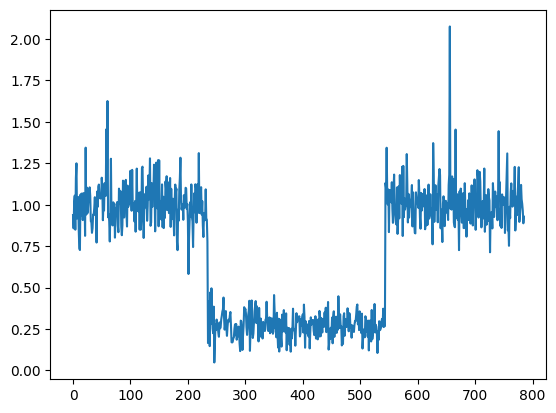

In [92]:
curve_Viscome_complete['Flux'].plot()

In [ ]:
evento = curve_Hanna_complete.Flux[250:500]
fora_evento = curve_Hanna_complete.Flux[:200]

In [ ]:
def tstudent(x,y):
    '''
    recebe dois data frames e retorna o valor do t e o grau de liberdade
    '''
    ux = x.mean()
    uy = y.mean()
    n = len(x)
    m = len(y)
    v = n + m - 2 ##nesse caso estamos comparando apenas dois tipos de dados, entao nosso grau de liberdade terá - dois
    if x.std() is False:
        x_std = 0
    else:
        x_std = x.std()
    if y.std() is False:
        y_std = 0
    else:
        y_std = y.std()
        
    s = np.sqrt((n*(x_std**2) + m*(y_std**2))/v)
    return (ux - uy)/(s*np.sqrt(m**(-1) + n**(-1))),v

def f_test(x,y):
    '''
    recebe dois data frames e retorna o valor do f e os graus de liberdade de x e y (nessa ordem)
    '''
    ux = x.mean()
    uy = y.mean()
    n = len(x)
    m = len(y)

    if x.std() is False:
        x_std = 0
    else:
        x_std = x.std()
    if y.std() is False:
        y_std = 0
    else:
        y_std = y.std()
    return (x_std**2)/(y_std**2),n-1,m-1


In [ ]:
import scipy.stats as stats
t_dist = np.linspace(-5,+5,1000)

prob = stats.t.pdf(x= t_dist, df=tstudent(evento,fora_evento)[1])
stats.t.ppf(1-0.01/2,df=tstudent(evento,fora_evento)[1]) #bicaudal -> 1% de incerteza

2.592316410844304

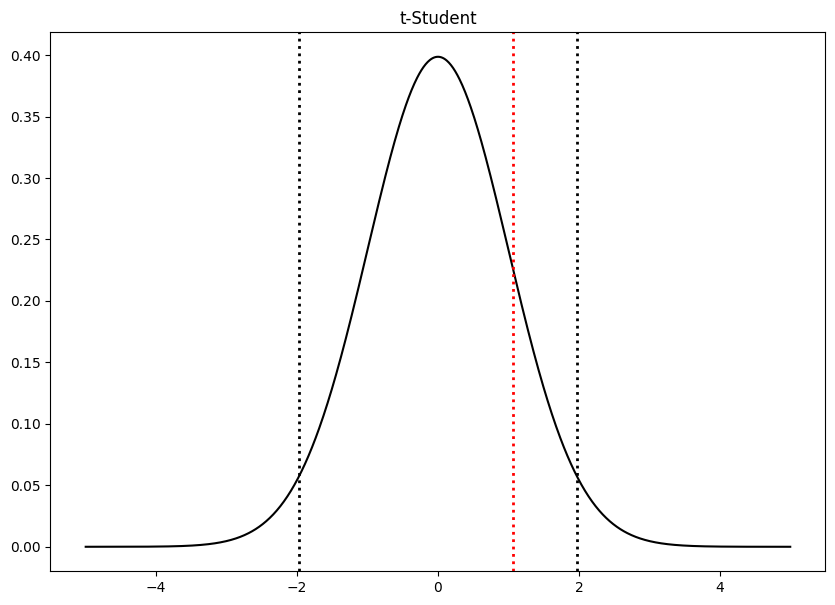

In [ ]:
plt.figure(figsize = [10,7])
plt.title('t-Student')
plt.plot(t_dist,prob,'k')
plt.axvline(tstudent(evento,fora_evento)[0], color='r', linestyle='dotted', linewidth=2) 
plt.axvline(stats.t.ppf(1-0.05/2,df=tstudent(evento,fora_evento)[1]), color='k', linestyle='dotted', linewidth=2) 
plt.axvline(-stats.t.ppf(1-0.05/2,df=tstudent(evento,fora_evento)[1]), color='k', linestyle='dotted', linewidth=2) 
plt.show()

In [ ]:
# Dados
evento = curve_Viscome_complete.Flux[250:500]
fora_evento = curve_Viscome_complete.Flux[:250]

Estatística KS: 0.1057843137254902
P-valor: 0.4005711765924107


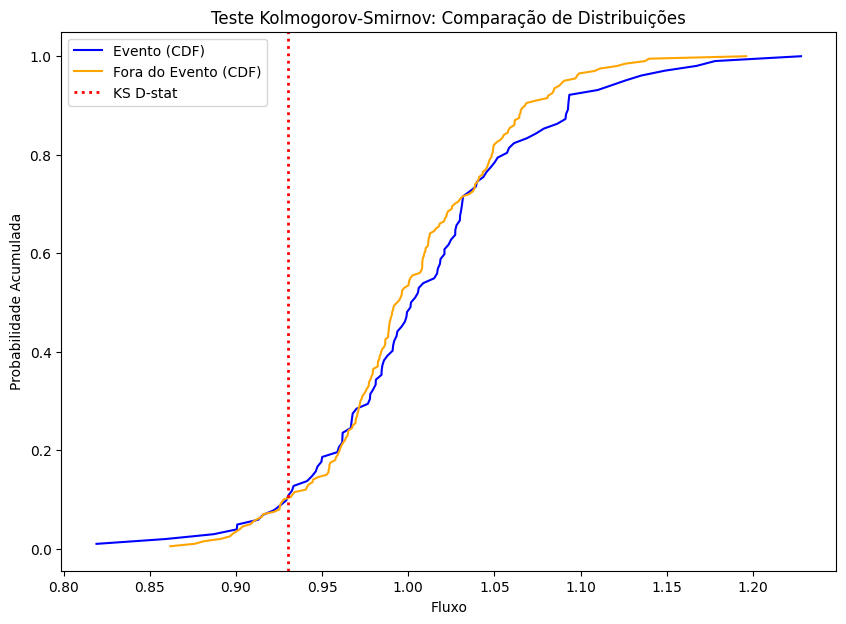

Falha em rejeitar H0: Não há evidência suficiente para afirmar que as distribuições são diferentes.


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Dados
#evento = curve_Hanna_complete.Flux[250:500]
#fora_evento = curve_Hanna_complete.Flux[:200]

# Teste KS de igualdade
def ks_test(x, y):
    """
    Recebe dois DataFrames ou arrays e retorna a estatística KS e o p-valor.
    """
    stat, p_value = stats.ks_2samp(x, y)
    return stat, p_value

# Realizando o teste
ks_stat, ks_p_value = ks_test(evento, fora_evento)

print(f"Estatística KS: {ks_stat}")
print(f"P-valor: {ks_p_value}")

# Plot da função de distribuição acumulada
plt.figure(figsize=[10, 7])
plt.title("Teste Kolmogorov-Smirnov: Comparação de Distribuições")
plt.xlabel("Fluxo")
plt.ylabel("Probabilidade Acumulada")

# Função de distribuição acumulada das amostras
evento_sorted = np.sort(evento)
fora_evento_sorted = np.sort(fora_evento)

evento_cdf = np.arange(1, len(evento_sorted)+1) / len(evento_sorted)
fora_evento_cdf = np.arange(1, len(fora_evento_sorted)+1) / len(fora_evento_sorted)

plt.plot(evento_sorted, evento_cdf, label="Evento (CDF)", color="blue")
plt.plot(fora_evento_sorted, fora_evento_cdf, label="Fora do Evento (CDF)", color="orange")
plt.axvline(evento_sorted[int(ks_stat * len(evento_sorted))], color='red', linestyle='dotted', label="KS D-stat", linewidth=2)

plt.legend()
plt.show()

# Interpretação do p-valor
if ks_p_value < 0.05:
    print("Rejeitamos H0: As distribuições são significativamente diferentes.")
else:
    print("Falha em rejeitar H0: Não há evidência suficiente para afirmar que as distribuições são diferentes.")


Estatística KS: 0.15
P-valor: 0.21117008625127576


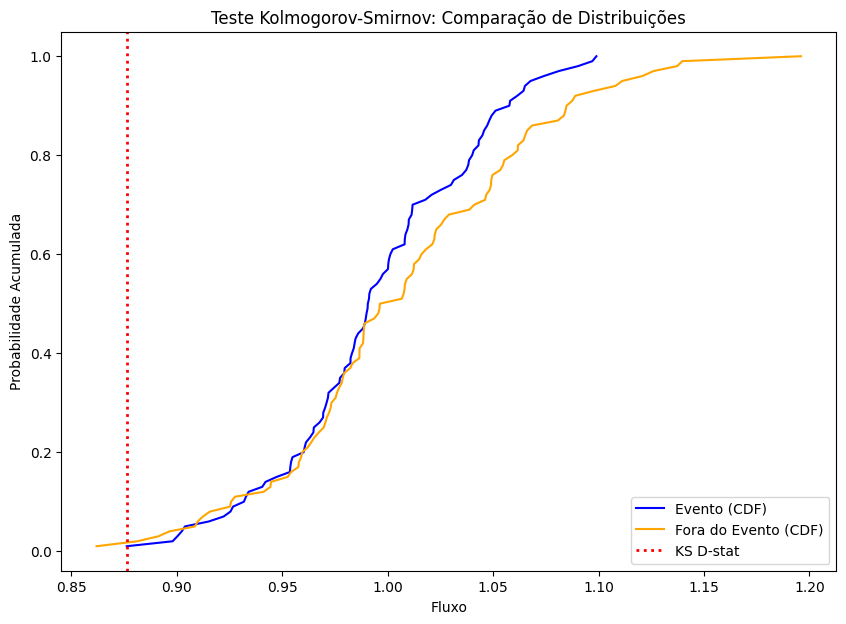

Falha em rejeitar H0: Não há evidência suficiente para afirmar que as distribuições são diferentes.


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Dados
evento = curve_Hanna_complete.Flux[100:200]
fora_evento = curve_Hanna_complete.Flux[:100]

# Teste KS de igualdade
def ks_test(x, y):
    """
    Recebe dois DataFrames ou arrays e retorna a estatística KS e o p-valor.
    """
    stat, p_value = stats.ks_2samp(x, y)
    return stat, p_value

# Realizando o teste
ks_stat, ks_p_value = ks_test(evento, fora_evento)

print(f"Estatística KS: {ks_stat}")
print(f"P-valor: {ks_p_value}")

# Plot da função de distribuição acumulada
plt.figure(figsize=[10, 7])
plt.title("Teste Kolmogorov-Smirnov: Comparação de Distribuições")
plt.xlabel("Fluxo")
plt.ylabel("Probabilidade Acumulada")

# Função de distribuição acumulada das amostras
evento_sorted = np.sort(evento)
fora_evento_sorted = np.sort(fora_evento)

evento_cdf = np.arange(1, len(evento_sorted) + 1) / len(evento_sorted)
fora_evento_cdf = np.arange(1, len(fora_evento_sorted) + 1) / len(fora_evento_sorted)

plt.plot(evento_sorted, evento_cdf, label="Evento (CDF)", color="blue")
plt.plot(fora_evento_sorted, fora_evento_cdf, label="Fora do Evento (CDF)", color="orange")

# Encontrando a posição do valor máximo da diferença entre as CDFs
max_diff_index = np.argmax(np.abs(evento_cdf - fora_evento_cdf))
ks_value = evento_sorted[max_diff_index]

# Adicionando a linha do KS-D stat no gráfico
plt.axvline(ks_value, color='red', linestyle='dotted', label="KS D-stat", linewidth=2)

plt.legend()
plt.show()

# Interpretação do p-valor
if ks_p_value < 0.05:
    print("Rejeitamos H0: As distribuições são significativamente diferentes.")
else:
    print("Falha em rejeitar H0: Não há evidência suficiente para afirmar que as distribuições são diferentes.")


> Falso Negativo é o pior -> evitar ao máximo!

<Axes: >

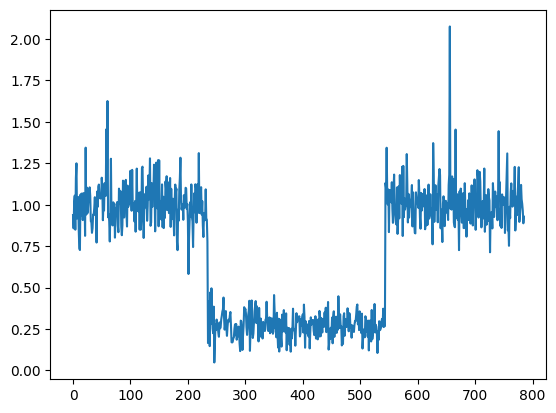

In [ ]:
curve_Viscome_complete.Flux.plot()

In [93]:
data_set = pd.DataFrame()
data_list = [curve_Kai_complete, curve_Tony_complete, curve_Viscome_complete, curve_Hanna_complete]

for data in data_list:
    if data.occ.sum() > 0:
        # Calcula as features para cada curva
        feature_row = {
            'Feature_Amp': data['Flux'].max() - data['Flux'].min(),
            'Feature_mv_av_Max': data['mv_av'].max(),
            'Feature_mv_av_Min': data['mv_av'].min(),
            'Feature_dFlux_Amp': data['dFlux'].max() - data['dFlux'].min(),
            'Feature_Flux_std': data['Flux'].std(),
            'occ': 1  # Obtém a classe (todas as linhas da curva têm a mesma 'occ')
        }
        # Adiciona como uma nova linha no data_set
        data_set = pd.concat([data_set, pd.DataFrame([feature_row])], ignore_index=True)

    else:
                # Calcula as features para cada curva
        feature_row = {
            'Feature_Amp': data['Flux'].max() - data['Flux'].min(),
            'Feature_mv_av_Max': data['mv_av'].max(),
            'Feature_mv_av_Min': data['mv_av'].min(),
            'Feature_dFlux_Amp': data['dFlux'].max() - data['dFlux'].min(),
            'Feature_Flux_std': data['Flux'].std(),
            'occ': 0  # Obtém a classe (todas as linhas da curva têm a mesma 'occ')
        }
        # Adiciona como uma nova linha no data_set
        data_set = pd.concat([data_set, pd.DataFrame([feature_row])], ignore_index=True)

In [94]:
data_set

,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_dFlux_Amp,Feature_Flux_std,occ
0,1.529520,1.099516,0.152464,0.103738,0.350446,1
1,1.191689,1.063643,0.312401,0.125067,0.208014,1
2,2.027945,1.280868,0.180884,0.273803,0.378359,1
3,0.408723,1.057302,0.939442,0.044881,0.059034,0


**O primeiro passo vai ser separar entre a nossa variável que queremos prever (Y) e quais vão ser as colunas que vamos usar para essa previsão (X)**

In [ ]:
Y = data_train.occ
X = data_train.drop('occ', axis=1)

In [ ]:
# Importando o modelo
from sklearn.linear_model import LinearRegression

# Instanciando
modelo_regressao = LinearRegression()

# Realizando o fit do modelo
modelo_regressao.fit(X,Y)

# Usando o modelo para prever os dados de teste
y_regressao = modelo_regressao.predict(data_test.drop('occ', axis=1))

In [ ]:
y_regressao

array([0.74564144])

<Axes: >

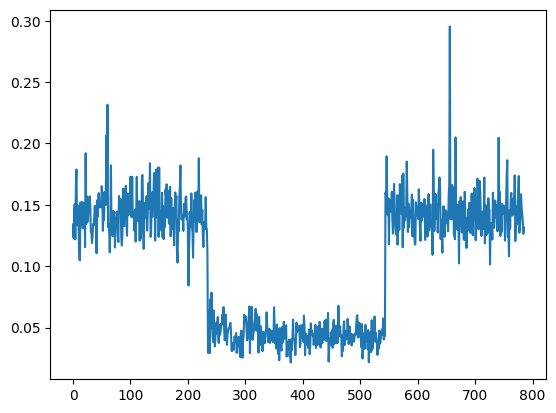

In [ ]:
curve_Viscome_complete.dFlux.plot(label='curva')

In [ ]:
profile = ProfileReport(curva_complete)
#profile.to_file("light_curve_parameters.html")
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

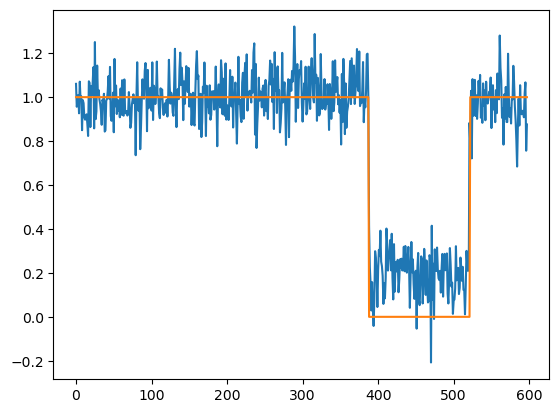

In [ ]:
curva_complete.Flux.plot(label='curva')
plt.plot(l)

In [ ]:
curva_complete['Tempo (sec)'].iloc[388:521] #Chute inicial para identifica;ao de uma occ

388   2,459,113.85
389   2,459,113.85
390   2,459,113.85
391   2,459,113.85
392   2,459,113.85
          ...     
516   2,459,113.85
517   2,459,113.85
518   2,459,113.85
519   2,459,113.85
520   2,459,113.85
Name: Tempo (sec), Length: 133, dtype: float64

In [ ]:
l = []

for i in curva_complete.index:
    if i < 388 or i>521:
        l.append(1)
    else:
        l.append(0)

In [ ]:
curva_complete['occ'] = l

In [ ]:
# Exemplo: função para simular a leitura de múltiplas curvas
def simulate_curves(n_curves, n_points): #fluxo ccd*gamma -> estatistica Poisson R/N
    curves = []
    targets = []
    for i in range(n_curves):
        time = np.linspace(0, 1, n_points)
        flux = 1 + 0.1 * np.random.randn(n_points)  # ruído gaussiano
        random = np.random.rand()
        if random > 0.5:  # 50% das curvas terão ocultação
            occult_start, occult_end = np.sort(np.random.choice(n_points, 2, replace=False))
            if round(random*100,0)%2 == 0:
                flux[occult_start:occult_end] -= flux[occult_start:occult_end].min()  # simula uma ocultação
            else:
                flux[occult_start:occult_end] -= flux[occult_start:occult_end].mean()  # simula uma ocultação
            targets.append(1)
        else:
            targets.append(0)
        curves.append(pd.DataFrame({'Tempo': time, 'Flux': flux}))
    return curves, targets

<Axes: >

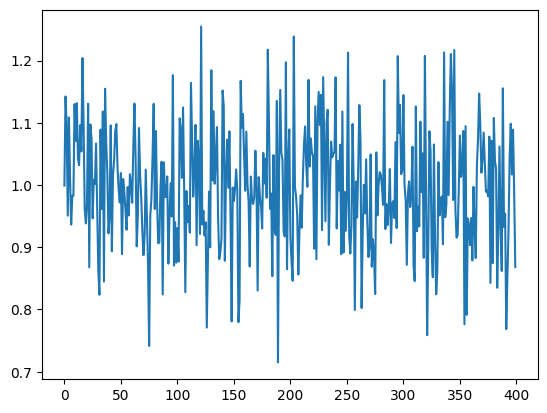

In [63]:
curva_simulada = simulate_curves(5, 400)

curva_simulada[0][0].Flux.plot()

In [78]:
simuladas_positivas = []
simuladas_negativas = []

for idx in range(len(curva_simulada[1])):
    info = curva_simulada[1][idx]
    if info == 1:
        simuladas_positivas.append(curva_simulada[0][idx])
    elif info == 0:
        simuladas_negativas.append(curva_simulada[0][idx])
    else:
        print("Error")

In [85]:
for curva in simuladas_positivas:
    curva['mv_av'] = moving_average(df=curva, column='Flux', window=int(len(curva)/40))
    curva['occ'] = 1

for curva in simuladas_negativas:
    curva['mv_av'] = moving_average(df=curva, column='Flux', window=int(len(curva)/40))
    curva['occ'] = 0

data_set_simulados = pd.DataFrame()

data_list = simuladas_negativas + simuladas_positivas

for data in data_list:
    if data.occ.sum() > 0:
        # Calcula as features para cada curva
        feature_row = {
            'Feature_Amp': data['Flux'].max() - data['Flux'].min(),
            'Feature_mv_av_Max': data['mv_av'].max(),
            'Feature_mv_av_Min': data['mv_av'].min(),
            'Feature_Flux_std': data['Flux'].std(),
            'occ': 1  # Obtém a classe (todas as linhas da curva têm a mesma 'occ')
        }
        # Adiciona como uma nova linha no data_set
        data_set_simulados = pd.concat([data_set_simulados, pd.DataFrame([feature_row])], ignore_index=True)

    else:
                # Calcula as features para cada curva
        feature_row = {
            'Feature_Amp': data['Flux'].max() - data['Flux'].min(),
            'Feature_mv_av_Max': data['mv_av'].max(),
            'Feature_mv_av_Min': data['mv_av'].min(),
            'Feature_Flux_std': data['Flux'].std(),
            'occ': 0  # Obtém a classe (todas as linhas da curva têm a mesma 'occ')
        }
        # Adiciona como uma nova linha no data_set
        data_set_simulados = pd.concat([data_set_simulados, pd.DataFrame([feature_row])], ignore_index=True)

In [86]:
data_set_simulados

,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,occ
0,0.540051,1.089194,0.920235,0.096792,0
1,0.531649,1.075946,0.931880,0.097062,0
2,1.366142,1.083972,0.161835,0.314351,1
3,1.255219,1.076112,0.319739,0.325647,1
4,1.245787,1.063194,0.151496,0.214383,1


In [107]:
data_train.drop(columns=['Feature_dFlux_Amp'])

,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,occ
1,1.191689,1.063643,0.312401,0.208014,1
2,2.027945,1.280868,0.180884,0.378359,1
3,0.408723,1.057302,0.939442,0.059034,0


### Modelo treinado com dados reais e testado em simulados:

In [108]:
data_train = data_set.iloc[1:].drop(columns=['Feature_dFlux_Amp'])
data_test = data_set.drop(columns=['Feature_dFlux_Amp'])

Y = data_train.occ
X = data_train.drop('occ', axis=1)

# Importando o modelo
from sklearn.linear_model import LinearRegression

# Instanciando
modelo_regressao = LinearRegression()

# Realizando o fit do modelo
modelo_regressao.fit(X,Y)

# Usando o modelo para prever os dados de teste
y_regressao = modelo_regressao.predict(data_test.drop('occ', axis=1))

In [109]:
y_regressao

array([ 1.21453176e+00,  1.00000000e+00,  1.00000000e+00, -4.44089210e-16])

In [110]:
modelo_regressao.predict(data_set_simulados.drop('occ', axis=1))

array([-0.00170344, -0.01320467,  1.22705703,  0.96728488,  1.27542569])

In [111]:
data_set_simulados

,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_Flux_std,occ
0,0.540051,1.089194,0.920235,0.096792,0
1,0.531649,1.075946,0.931880,0.097062,0
2,1.366142,1.083972,0.161835,0.314351,1
3,1.255219,1.076112,0.319739,0.325647,1
4,1.245787,1.063194,0.151496,0.214383,1


 > SUCESSO!

### Modelo treinado com dados simulados e testado em reais:

In [113]:
data_train = data_set_simulados.iloc[1:]#.drop(columns=['Feature_dFlux_Amp'])
data_test = data_set_simulados#.drop(columns=['Feature_dFlux_Amp'])

Y = data_train.occ
X = data_train.drop('occ', axis=1)

# Importando o modelo
from sklearn.linear_model import LinearRegression

# Instanciando
modelo_regressao = LinearRegression()

# Realizando o fit do modelo
modelo_regressao.fit(X,Y)

# Usando o modelo para prever os dados de teste
y_regressao = modelo_regressao.predict(data_test.drop('occ', axis=1))

In [114]:
y_regressao

array([-1.31354635e-01, -1.77635684e-15,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00])

In [116]:
y_regressao = modelo_regressao.predict(data_set.drop(columns=['Feature_dFlux_Amp']).drop('occ', axis=1))

In [117]:
y_regressao

array([ 0.79568777,  0.7743975 , -1.63800596,  0.18500461])

In [118]:
data_set

,Feature_Amp,Feature_mv_av_Max,Feature_mv_av_Min,Feature_dFlux_Amp,Feature_Flux_std,occ
0,1.529520,1.099516,0.152464,0.103738,0.350446,1
1,1.191689,1.063643,0.312401,0.125067,0.208014,1
2,2.027945,1.280868,0.180884,0.273803,0.378359,1
3,0.408723,1.057302,0.939442,0.044881,0.059034,0


 > Perda de precisão e queda de acurácia. Curva Tony fugiu bem dos padrões sintéticos e isso confundiu o algoritmo. Indicativo de que teremos que melhorar a função que cria curvas sintéticas

### Sketch Data Warehouse:

> Criando arquivo .db e interagir com ele via sqlite3

> Buscar dados de: https://occultation.trgozlemevleri.gov.tr, https://astro.troja.mff.cuni.cz/projects/damit/, https://alcdef.org/, https://sodis.iota-es.de

In [ ]:
import sqlite3

connection = sqlite3.connect("survey.db")
cursor = connection.cursor()
cursor.execute("SELECT Site.lat, Site.long FROM Site;") #Atenção às colunas!
results = cursor.fetchall()
for r in results:
    print(r)
cursor.close()
connection.close()

OperationalError: no such table: Site

In [ ]:
def get_name(database_file, person_id):
    query = "SELECT personal || ' ' || family FROM Person WHERE id=?;" #maior nivel de segurança invés de "SELECT personal || ' ' || family FROM Person WHERE id='" + person_id + "';" DROP

    connection = sqlite3.connect(database_file)
    cursor = connection.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    cursor.close()
    connection.close()

    return results[0][0]

print("Full name for dyer:", get_name('survey.db', 'dyer'))

def add_name(database_file, new_person):
    query = "INSERT INTO Person (id, personal, family) VALUES (?, ?, ?);"

    connection = sqlite3.connect(database_file)
    cursor = connection.cursor()
    cursor.execute(query, list(new_person))
    cursor.close()
    connection.close()


def get_name(database_file, person_id):
    query = "SELECT personal || ' ' || family FROM Person WHERE id=?;"

    connection = sqlite3.connect(database_file)
    cursor = connection.cursor()
    cursor.execute(query, [person_id])
    results = cursor.fetchall()
    cursor.close()
    connection.close()

    return results[0][0]

# Insert a new name
add_name('survey.db', ('barrett', 'Mary', 'Barrett'))
# Check it exists
print("Full name for barrett:", get_name('survey.db', 'barrett'))

A ideia aqui é buscar as curvas de luz nos portais publicos + drive do grupo, organiza-las e uploada-las nesse banco de dados SQL para que facilite o acesso e mantenha na formatação correta os mesmos dados utilizados no modelo. 